In [1]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


2022-05-06 21:01:42.447955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 21:01:42.477640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 21:01:42.477803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 21:01:42.478202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [3]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"], # splits can be a little tricky, for more see: https://www.tensorflow.org/datasets/splits 
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

2022-05-06 21:01:43.301304: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-06 21:01:43.302048: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 21:01:43.302212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 21:01:43.302327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [6]:
class_names = ds_info.features['label'].names


    Image shape: (512, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target class from Food101 (tensor form): 43
    Class name (str form): fried_calamari
    


Text(0.5, 1.0, 'fried_calamari')

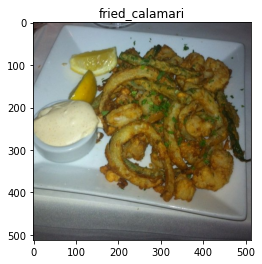

In [7]:
train_one_sample = train_data.take(1)
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image datatype: {image.dtype}
    Target class from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)
plt.imshow(image.numpy()/255.)
plt.title(class_names[label.numpy()])

In [8]:
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image datatype: {image.dtype}
    Target class from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)


    Image shape: (512, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target class from Food101 (tensor form): 21
    Class name (str form): chocolate_cake
    


In [10]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

In [11]:
def preprocess_image(image, label, size=224):
    image = tf.image.resize(image, [size,size])
    return tf.cast(image, tf.float32), label
    

In [12]:
test = preprocess_image(image, label)
test[0]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[2.9198980e+01, 1.1198979e+01, 0.0000000e+00],
        [2.8285715e+01, 1.2285714e+01, 0.0000000e+00],
        [3.0852041e+01, 1.5494898e+01, 2.8061217e-01],
        ...,
        [5.2933601e+01, 3.2505074e+01, 8.7193365e+00],
        [5.4025528e+01, 3.4025528e+01, 1.0025528e+01],
        [5.3800972e+01, 3.3800972e+01, 9.5713587e+00]],

       [[3.3096939e+01, 1.5096939e+01, 1.1938781e+00],
        [3.3785713e+01, 1.7785715e+01, 2.7857151e+00],
        [3.1785713e+01, 1.6428572e+01, 1.2142859e+00],
        ...,
        [6.3602058e+01, 4.2530632e+01, 1.5346998e+01],
        [6.1647934e+01, 4.0785702e+01, 1.3928558e+01],
        [6.0785713e+01, 4.1714287e+01, 1.2020403e+01]],

       [[3.1576530e+01, 1.3576531e+01, 6.4285755e-01],
        [3.3357147e+01, 1.7357143e+01, 2.3571434e+00],
        [3.6168365e+01, 2.0811226e+01, 5.5969391e+00],
        ...,
        [6.7688797e+01, 4.4474506e+01, 1.0852092e+01],
        [6.9959167e+01

In [13]:
train_data = train_data.map(map_func=preprocess_image, 
                            num_parallel_calls=tf.data.AUTOTUNE,#lets cpu use more than 1 core
                           )

train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_image, 
                            num_parallel_calls=tf.data.AUTOTUNE,#lets cpu use more than 1 core
                           )

test_data = test_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)



In [14]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

In [15]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training 
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor='val_accuracy',
                                                     save_best_only=True,
                                                     save_weights_only=True,
                                                     verbose=0)

In [16]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

# compile
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [18]:
for layer in model.layers:
    print(layer.name, layer.dtype, layer.trainable, layer.dtype_policy)

input_layer float32 True <Policy "float32">
efficientnetb0 float32 False <Policy "mixed_float16">
global_average_pooling2d float32 True <Policy "mixed_float16">
dense float32 True <Policy "mixed_float16">
softmax_float32 float32 True <Policy "float32">


In [19]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers[:20]: # check the layers of the base model (layer at index 1 of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

In [20]:
history_run_1 = model.fit(train_data,
                        epochs=3,
                        steps_per_epoch=(len(train_data)),
                        validation_data=test_data,
                        validation_steps=int(0.15 * len(test_data)), # validate on only 15% of test data during training
                        callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220506-210145
Epoch 1/3


2022-05-06 21:01:50.274913: E tensorflow/stream_executor/cuda/cuda_dnn.cc:373] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2022-05-06 21:01:50.274987: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops.cc:1120 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Graph execution error:

Detected at node 'model/efficientnetb0/stem_conv/Conv2D' defined at (most recent call last):
    File "/home/jason/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/jason/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/jason/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/jason/anaconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/jason/anaconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/jason/anaconda3/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/home/jason/anaconda3/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/home/jason/anaconda3/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/jason/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/jason/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/jason/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
      result = self._run_cell(
    File "/home/jason/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2900, in _run_cell
      return runner(coro)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/jason/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3301, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/jason/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3361, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_6482/3876190698.py", line 1, in <cell line: 1>
      history_run_1 = model.fit(train_data,
    File "/home/jason/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jason/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/jason/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/jason/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/keras/layers/convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/jason/anaconda3/lib/python3.9/site-packages/keras/layers/convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'model/efficientnetb0/stem_conv/Conv2D'
DNN library is not found.
	 [[{{node model/efficientnetb0/stem_conv/Conv2D}}]] [Op:__inference_train_function_15717]

In [ ]:
# results_feature_extract_model = model.evaluate(test_data)
# results_feature_extract_model

# TODO: Save the whole model to file

In [ ]:
model.save('my7model')

In [ ]:
model = tf.keras.models.load_model("my7model")

In [ ]:
for layer in model.layers:
    print(layer.name, layer.dtype, layer.trainable, layer.dtype_policy)

In [ ]:
model.evaluate(test_data)

# TODO: Preparing our model's layers for fine-tuning
Next: Fine-tune the feature extraction model to beat the DeepFood paper.

Like all good cooking shows, I've saved a model I prepared earlier (the feature extraction model from above) to Google Storage.

You can download it to make sure you're using the same model as originall trained going forward.

In [ ]:
model2 = tf.keras.models.load_model("providedmodelfor7")

In [ ]:
model.summary(), model2.summary()

In [ ]:
model2.evaluate(test_data)

In [ ]:
model2.trainable = True

In [ ]:
for layer in model2.layers:
    print(layer.name, layer.dtype, layer.trainable, layer.dtype_policy)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [ ]:
# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint for more
# YOUR_CODE_HERE

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [ ]:
model2.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
              metrics=["accuracy"])

In [ ]:
history_run_2 = model2.fit(train_data,
                        epochs=100,
                        steps_per_epoch=(len(train_data)),
                        validation_data=test_data,
                        validation_steps=int(0.15 * len(test_data)), # validate on only 15% of test data during training
                        callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                experiment_name="efficientnetb0_101_classes_all_data_fine_tuning"),
                                                                model_checkpoint,
                                                                  early_stop,
                                                                reduce_lr])

In [ ]:
model2.save('2my7model')

In [ ]:
model2.evaluate(test_data)

In [ ]:
# Start to fine-tune (all layers)
# Use 100 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier
# YOUR_CODE_HERE
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
# Evaluate mixed precision trained fine-tuned model (this should beat DeepFood's 77.4% top-1 accuracy)

# TODO: View training results on TensorBoard
To do: Upload and view your model's training results to TensorBoard.dev and view them.

See https://tensorboard.dev/ for more.

In [ ]:
# YOUR_CODE_HERE

# TODO: Evaluate your trained model
Some ideas you might want to go through:

Find the precision, recall and f1 scores for each class (all 101).
Build a confusion matrix for each of the classes.
Find your model's most wrong predictions (those with the highest prediction probability but the wrong prediction).
See the evaluation section at the end of Transfer Learning Part 3: Scaling Up for more.


In [ ]:
# YOUR_CODE_HERE

# 🛠 Exercises
Use the same evaluation techniques on the large-scale Food Vision model as you did in the previous notebook (Transfer Learning Part 3: Scaling up). More specifically, it would be good to see:
A confusion matrix between all of the model's predictions and true labels.
A graph showing the f1-scores of each class.
A visualization of the model making predictions on various images and comparing the predictions to the ground truth.
For example, plot a sample image from the test dataset and have the title of the plot show the prediction, the prediction probability and the ground truth label.
Take 3 of your own photos of food and use the Food Vision model to make predictions on them. How does it go? Share your images/predictions with the other students.
Retrain the model (feature extraction and fine-tuning) we trained in this notebook, except this time use EfficientNetB4 as the base model instead of EfficientNetB0. Do you notice an improvement in performance? Does it take longer to train? Are there any tradeoffs to consider?
Name one important benefit of mixed precision training, how does this benefit take place?
# 📖 Extra-curriculum
Read up on learning rate scheduling and the learning rate scheduler callback. What is it? And how might it be helpful to this project?
Read up on TensorFlow data loaders (improving TensorFlow data loading performance). Is there anything we've missed? What methods you keep in mind whenever loading data in TensorFlow? Hint: check the summary at the bottom of the page for a gret round up of ideas.
Read up on the documentation for TensorFlow mixed precision training. What are the important things to keep in mind when using mixed precision training?